In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# digitsデータを使うためにimportする
from torchvision.datasets import MNIST

## GPUを使える場合はGPUを使うための準備

In [3]:
# GPUを使える場合はGPUを使うための準備
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


## 多層パーセプトロンでの画像分類をPyTorchで実装する際のステップは以下の通り
- step1: データの読み込み
- step2: ネットワークの定義
- step3: 損失関数の定義 
- step4: 最適化関数の定義
- step5: 学習（講義コードはここまで）
- step6: 学習したネットワークを使って未知データの予測

## step1: データの読み込み
---
trainデータとtestデータをダウンロード

In [7]:
trainset = MNIST(root='./data',
                     train=True,
                     download=True)

testset = MNIST(root='./data',
                    train=False,
                    download=True)

In [8]:
print(trainset.train_data.shape)
print(trainset.train_labels.shape)

print(testset.test_data.shape)
print(testset.test_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


Target:  tensor(4)


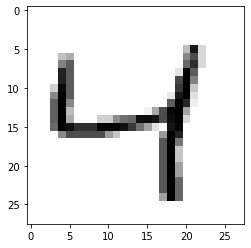

In [6]:
idx = 2
plt.imshow(trainset.train_data[idx], cmap=plt.cm.gray_r, interpolation='nearest')
print("Target: ", trainset.train_labels[idx])

## TensorDatasetを作成後、DataLoaderを作成
---
TensorDatasetは特徴量Xとラベルyをまとめるデータ構造です。<br>
そのTensorDatasetをDataLoaderに渡すことで、forループでデータの一部のみを受け取れるようにします。

In [6]:
X_train_tensor = trainset.train_data.reshape(trainset.train_data.shape[0], -1).type(torch.float32) # 行数だけ残して、残りはフルフラット　　　-1は残り全部なしだよー
y_train_tensor = trainset.train_labels.type(torch.int64)

X_test_tensor = testset.test_data.reshape(testset.test_data.shape[0], -1).type(torch.float32)
y_test_tensor = testset.test_labels.type(torch.int64)

In [7]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

In [8]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

## Step2: ネットワークの定義

In [9]:
net = nn.Sequential(
    nn.Linear(28*28,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)
net

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

## Step3: 目的関数に交差エントロピー誤差関数を用意（損失関数の定義）

In [10]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Step4: Optimizerを定義する（最適化関数の定義）
---
今回はAdamを利用します。

In [0]:
optimizer = optim.Adam(net.parameters())

## GPUに転送
---
GPUはCPUと違って、計算処理を順番に行うのではなく、並行化して行うことができます。<br>
Deep Learningでは膨大な量の行列計算を行うので、GPUを利用し並列化して計算を行うと高速化が見込めます。

In [0]:
net = net.to(device)

## step5: 学習

In [0]:
train_loss_track = []
test_loss_track = []

for epoc in range(10):
    running_loss = 0
    
    # 学習モード
    net.train()
    for step, (xx, yy)  in enumerate(train_loader):
        
        # device = "cuda"の場合、GPUにデータを転送する
        xx = xx.to(device)
        yy = yy.to(device)
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = net(xx)
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
        
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って損失を計算
        running_loss += loss.item()
        
    # エポックが終了したら平均損失を計算
    train_loss_track.append(running_loss/step)
    
    
    #評価（evaluation）モード
    net.eval()
    
    # device = "cuda"であれば評価用データをGPUに転送する
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    # 予測値を計算
    y_pred = net(X_test_tensor)
    
    # 交差エントロピー誤差関数を計算
    test_loss = loss_func(y_pred, y_test_tensor)
    
    # 誤差をトラッキング
    test_loss_track.append(test_loss)

## 交差エントロピー誤差の推移

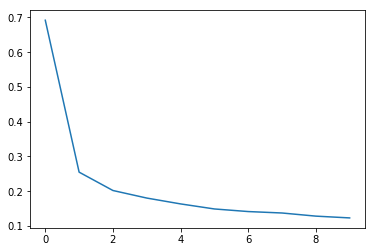

In [15]:
plt.plot(train_loss_track)

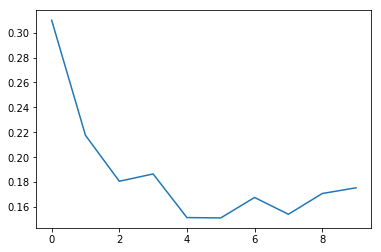

In [16]:
plt.plot(test_loss_track)

## testデータでAccuracyを計算

In [17]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in test_loader:
        
        # device = "cuda"の場合、GPUにデータを転送する
        test_xx = test_xx.to(device)
        test_yy = test_yy.to(device)

        outputs = net(test_xx)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        
        total += test_yy.size(0)
        true += (predicted == test_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

Accuracy: 95.04 %


## testデータで混同行列を作成

In [18]:
labels = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds, labels=labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0.0,966,0,1,1,0,3,3,2,4,0
1.0,0,1113,6,4,0,1,1,0,10,0
2.0,12,2,974,12,0,1,6,2,23,0
3.0,1,0,6,968,0,13,0,4,17,1
4.0,1,1,2,1,923,6,12,5,7,24
5.0,6,0,1,17,0,841,6,2,16,3
6.0,8,1,3,0,3,14,921,0,8,0
7.0,3,1,44,11,0,4,1,940,12,12
8.0,5,0,5,5,2,6,3,1,947,0
9.0,7,6,1,20,18,11,0,4,31,911
